In [23]:
import ROOT, rat
import os, sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
sys.path.append('/home/jp/projects/python_tools')
import jp_mpl as jplot
from jp_analysis import *
import rat

In [24]:
infile_dir = '/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_gdisc_model'


In [25]:
infile_name = 'thebox_337nm_diffuse.root'

In [26]:
try:
    ratreader.close()
    print 'Closing file before reopenning'
except:
    print 'No ratreader file. Opening it for the first time'
fname = os.path.join(infile_dir, infile_name)
if os.path.isfile(fname): print 'File exists'
ratreader = rat.dsreader(fname)

Closing file before reopenning
File exists


In [27]:
def doRead(single = False):
    photons_steps = [] # List of tracks
    photons_p     = []
    photons_ids   = []
    volumes       = []
    process       = []
    for ds, run in ratreader:
        mymc = ds.GetMC()
        for itrack in range(1, mymc.GetMCTrackCount()+1):
            mytrack = mymc.GetMCTrack(itrack)
            
            # End here to study the info in a track
            if single:
                return mytrack
            
            volumes.append([])
            process.append([])
            photons_steps.append(np.zeros(3))
            photons_p.append(np.zeros(3))
            
            photons_ids.append(mytrack.GetTrackID())
            
            #if pdg_code != 22: 
            #    # Particle is not a gamma
            #    continue
            
            for istep in range(mymc.GetMCTrack(itrack).GetMCTrackStepCount()):
                photons_steps[-1] = np.vstack((photons_steps[-1], np.zeros(3)))
                photons_p[-1] = np.vstack((photons_p[-1], np.zeros(3)))

                mystep = mymc.GetMCTrack(itrack).GetMCTrackStep(istep)
                position = mystep.GetPosition()
                momentum = mystep.GetMomentum()
                position.GetXYZ(photons_steps[-1][-1,:])
                momentum.GetXYZ(photons_p[-1][-1,:])
                process[-1].append(mystep.GetProcess())
                volumes[-1].append(mystep.GetEndVolume())

                
    ratreader.close()
    
    hcvalue = 1.239841 # eV*um (electronvolts times micrometer)
    
    return photons_steps, photons_p, volumes, \
           process, np.array(photons_ids)

In [28]:
#r = doRead(single = True)

In [29]:
pos, mom, volumes,proc, ids = doRead()

In [30]:
len(pos)

100000

In [31]:
# Need only those that are reflected from the PMT ... so I need at least 2 steps, right?

In [32]:
# Following a photon
index = 1
print 'Position'
print pos[index]
print 'Momentum'
print mom[index]
print 'End volume'
print volumes[index]
print 'Processes'
print proc[index]
print 'Track ID'
print ids[index]


Position
[[    0.             0.             0.        ]
 [   15.67576504    73.50461578   130.5       ]
 [   15.76173973    73.55891418   130.3999939 ]
 [   16.78087234    84.00509644   130.40332031]
 [   16.78087234    84.00509644   130.40332031]
 [   16.7110939     84.08904266   130.5       ]
 [   16.13373184    84.78366089   131.30000305]
 [ -610.80895996   839.0513916   1000.        ]]
Momentum
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.21238702e-06   1.39726683e-06  -2.57330294e-06]
 [  2.21238702e-06   1.39726683e-06  -2.57330294e-06]
 [ -1.75613229e-06   2.11278325e-06   2.43332011e-06]
 [ -1.75613229e-06   2.11278325e-06   2.43332011e-06]
 [ -1.75613229e-06   2.11278325e-06   2.43332011e-06]
 [ -1.75613229e-06   2.11278325e-06   2.43332011e-06]
 [ -1.75613229e-06   2.11278325e-06   2.43332011e-06]]
End volume
['world', 'r1408_pmtenv0', 'GDOut', 'r1408_pmtenv0', 'planewave', 'world', 'NULL']
Processes
['Unknown', 'Transportation', 'Unknown', 'G4FastSimulationMa

In [33]:
for momentum in mom[index]:
    print momentum/np.linalg.norm(momentum)

[ nan  nan  nan]
[ 0.60283027  0.38072667 -0.70117249]
[ 0.60283027  0.38072667 -0.70117249]
[-0.47851015  0.57569025  0.66302999]
[-0.47851015  0.57569025  0.66302999]
[-0.47851015  0.57569025  0.66302999]
[-0.47851015  0.57569025  0.66302999]
[-0.47851015  0.57569025  0.66302999]


/home/jp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


In [34]:
# The particles that end up in NULL made it out of the PMT
# If the momentum in x in the second step is negative it goes away from the PMT
# Positive momentum goes towards the PMT -- done

# I put the zeros there myself, dont look at them
# If the length of end volume or processes is 2, then the particle wasnt reflected
# If the last volume is the 'r_1408_pmt' then the particle as absorbed
# Gotta be careful with reflections from the outside of the PMT volume ... 
# These reflections wouldn't be a problem if I could put a cylindrical cap instead of the box
# Easy fix: only take photons that are emitted within the radius of the concentrator (see gdisc radius)
# Last momentum needs to have negative x
# End volume needs to be NULL
# Re-run with a smaller world to avoid scattering in the water ... also, change to heavy water

In [35]:
good_pos = []
good_mom = []
all_volumes = []
all_proc = []
gdisc_radius = 137.7
for iPhoton in range(len(pos)):
    
    # Only use photons produced on the side of my volume looking at the PMT
    # This won't change the conclusions of the study (material doesn't change)
    # but it matters for the first reflection study
    if pos[iPhoton][1][2] > 130.9:
        continue    
    
    # Look at px of step 1 (step 0 is zero by construction) - only take negatives
    if mom[iPhoton][1][2] > 0:
        continue

    # Last step needs to be going outwards
    if mom[iPhoton][-1][2] < 0:
        continue

    # Calculate the radius at emission point, only take those starting within the gdisc radius 
    r = np.sqrt(np.sum(pos[iPhoton][1][:2]**2))
    if r > gdisc_radius:
        continue
        
    if volumes[iPhoton][-1] != 'NULL':
        continue
        
    
    # Keep all these photons
    # I could do my operations here, but I'll store them for now
    good_pos.append(pos[iPhoton])
    good_mom.append(mom[iPhoton])
    all_volumes.append(volumes[iPhoton])
    all_proc.append(proc[iPhoton])

In [36]:
len(good_pos)

5996

In [37]:
# Contents of the output dictionary
# Recall the PMT rotational symmetry is around the x-axis
# y - starting position in y (front, back)
# z - starting position in z (up, down)
# xr - position (xyz) of the reflection 
# momentum - incoming momentum vector
# theta_i
# phi_i
# theta_f
# phi_f


keys = ['nsteps', 'y','x', 'xr', 'theta_i', 'phi_i','theta_f','phi_f','momentum',]
data = {}
for iKey in keys:
    if iKey != 'momentum':
        data[iKey] = np.zeros(len(good_pos))
data['momentum'] = np.zeros([len(good_pos), 3])
data['xr']       = np.zeros([len(good_pos), 3])


normal = np.array([0, 0, 1])

stop_at = -1

for iPhoton in range(len(good_pos)):
    data['x'][iPhoton] = good_pos[iPhoton][1][0]
    data['y'][iPhoton] = good_pos[iPhoton][1][1]
    
    
    # Because I'm looking at the reflection, the x should come from the *second* step
    # Remember, step 0 is nothing, 1 is the first position, 2 is the reflection (starting point)
    
    # I have to look at the 3rd position because the 2nd one seems to be still an effect of the surface
    data['xr'][iPhoton,:] = good_pos[iPhoton][3][:]
    #for one_step in range(good_pos[iPhoton].shape[0]):
    #    if data['xr'][iPhoton,0] < good_pos[iPhoton][one_step][0]:
    #        data['xr'][iPhoton,:] = good_pos[iPhoton][one_step][:]

    data['momentum'][iPhoton,:] = good_mom[iPhoton][1][:]
    
    # The negative value is because the theta is negative - otherwise I would need to correct for it later
    data['theta_i'][iPhoton] = np.arccos(np.dot(normal, 
                                                -getNorm(good_mom[iPhoton][1])))
    
    # The phi is obtained 
    data['phi_i'][iPhoton]   = np.arctan2(good_mom[iPhoton][1][1],
                                          good_mom[iPhoton][1][0])
    
    data['theta_f'][iPhoton] = np.arccos(np.dot(normal, 
                                                getNorm(good_mom[iPhoton][-1])))
    
    # This is not correct, should be momentum
    data['phi_f'][iPhoton]   = np.arctan2(good_mom[iPhoton][-1][1], 
                                   good_mom[iPhoton][-1][0])
    
    if iPhoton % 10000 == 0:
        print iPhoton
        
    if iPhoton == stop_at:
        print 'Momentum'
        print good_mom[iPhoton]
        print 'Position'
        print good_pos[iPhoton]
        break
    
    data['nsteps'][iPhoton] = len(good_pos[iPhoton])

0


In [38]:
data['r'] = np.sqrt(data['x']**2 + data['y']**2)
phidiff = (data['phi_f'] - data['phi_i'])
phidiff[phidiff<0] += np.pi*2
data['phidiff'] = phidiff

In [39]:
phidiff = data['phi_f'] - data['phi_i']

In [40]:
print data['phi_i'][:10]
print data['phi_f'][:10]


[ 0.56330649  1.82310386  2.94109654 -1.89414649 -1.48247316 -0.90115459
 -2.05587276 -0.41878945 -0.22014391  0.09149709]
[ 2.26427059 -2.173925    3.03193414 -1.18144088  2.65751065  2.49163012
 -2.77213166  0.84778772  2.63343039 -2.33226032]


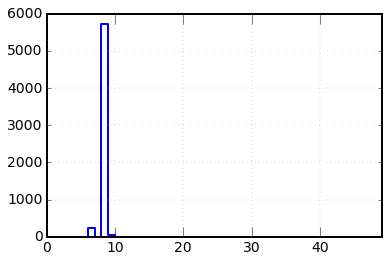

In [41]:
b,x = np.histogram(data['nsteps'],np.arange(0, 50, 1))
jplot.unfilledBar(x,b)

In [42]:
np.sum(data['nsteps'] < 16)

5994

In [43]:
import pickle
outname = 'condensed_' + infile_name.rstrip('.root') + '.pckl'
pickle.dump(data, open('/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_gdisc_model/'+outname,'w'))